# Proyecto final Inteligencia Computacional
## Style Transfer
### [Ammi Beltrán Troppa, Fernanda Borja Muñoz]

# Imports

In [1]:
import os
import io
import sys
import time
#
import numpy as np
import torch
from torch import nn
import torchvision
from matplotlib import pyplot as plt
#
import zipfile
#
from PIL import Image
from torch.utils.data import Dataset
from natsort import natsorted
from torchvision import datasets, transforms

# Encoder y Decoder

## Encoder

In [2]:
class Encoder(nn.Module):
  def __init__(self,layer = 15): 
    super().__init__()
    fully_model = torchvision.models.vgg16(weights = torchvision.models.vgg.VGG16_Weights.DEFAULT).eval().features
    self.model = fully_model[:layer + 1]

  def forward(self,x):
    return self.model(x)

In [3]:
Encode = Encoder(layer= 15)
Encode

Encoder(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
  )
)

## Decoder Conv2d

In [4]:
class Decoder(nn.Module):
  def __init__(self,layer = 14):
    super().__init__()
    fully_decoder = nn.Sequential(

        # Primera capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        
        # Segunda Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

        #Tercera Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        
        #Cuarta Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        

        #Quinta Capa
        nn.Upsample(scale_factor=(2,2), mode='nearest'),
        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True),
        nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        nn.ReLU(inplace = True), 
    )
    self.model = fully_decoder[layer:29]

  def forward(self,x):
    return self.model(x)

In [5]:
Decode = Decoder(layer = 14)
Decode

Decoder(
  (model): Sequential(
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU(inplace=True)
    (20): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
    (21): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (22): ReLU(inplace=True)
    (23): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (24): ReLU(inplace=True)
    (25): Upsample(scale_factor=(2.0, 2.0), mode=nearest)
    (26): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (27): ReLU(inplace=True)
    (28): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

# Data 

## VSCode

Entrenamiento

In [6]:
# dir = "test2017/test2017"
# obj = natsorted(os.listdir(dir))
# #Entonces puedo armar una lista con todas las direcciones
# dirTrain = []
# for i in range(0, len(obj)):
#    dirTrain.append(os.path.join(dir, obj[i]))

In [7]:
#len(dirTrain)

Validación

In [8]:
# dir = "val2017/val2017"
# obj = natsorted(os.listdir(dir))
# # #Entonces puedo armar una lista con todas las direcciones
# dirVal = []
# for i in range(0, len(obj)):
#    dirVal.append(os.path.join(dir, obj[i]))

In [9]:
#len(dirVal)

# Dataset

## Transformaciones

In [10]:
transform1 = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            ])

denormalize = transforms.Normalize((-(0.485/0.229), -(0.456/0.224), -(0.406/0.225)), ((1/0.229), (1/0.224), (1/0.255))) 


## CustomDataset (para imagenes)

In [11]:
class CustomDataSetImg(Dataset):
    def __init__(self, imagelist, transform):
        super().__init__()
        self.imagepaths = imagelist
        self.transform = transform

    def __len__(self):
        return len(self.imagepaths)

    def __getitem__(self, index):
        self.imagepath = self.imagepaths[index]
        self.image = Image.open(self.imagepath).convert('RGB')

        self.i = self.transform(self.image)
        return self.i.detach(), self.imagepath

## CustomDataset (para tensores)

In [12]:
class CustomDataSetTensor(Dataset):
    def __init__(self, imagelist, encoder):
        super().__init__()
        self.imagepaths = imagelist
        self.transform = encoder

    def __len__(self):
        return len(self.imagepaths)

    def __getitem__(self, index):
        image = torch.load(self.imagepaths[index])

        feature = self.transform(image.to('cuda'))
        
        return feature.cpu(), image.cpu()

## Trabajo con datos

### Ejecutar una vez

In [13]:
# #OJITO, Crear carpeta de imagenes antes
# #Codigo para guardar como los tensores ya procesados en una carpeta, mejora un poco los tiempos de ejecucion del procesamiento c:
# Data_imagenes = CustomDataSetImg(dirTrain, transform = transform1)
# for img in Data_imagenes:
#     torch.save(obj = img[0], f = f'img/train/{img[1][18:30]}.pt')

In [14]:
# #OJITO, Crear carpeta de imagenes antes
# #Codigo para guardar como los tensores ya procesados en una carpeta, mejora un poco los tiempos de ejecucion del procesamiento c:
# Data_imagenes = CustomDataSetImg(dirVal, transform = transform1)
# for img in Data_imagenes:
#     torch.save(obj = img[0], f = f'img/val/{img[1][16:28]}.pt')

### Creador de Arrays

In [15]:
# #Trabajo con los .pt
# dir = "img/train"
# obj = os.listdir(dir)
# # Entonces puedo armar una lista con todas las direcciones
# dirTrain = []
# for i in range(0, len(obj)):
#    dirTrain.append(os.path.join(dir, obj[i]))

In [16]:
#Trabajo con los .pt
dir = "val"
obj = os.listdir(dir)
# Entonces puedo armar una lista con todas las direcciones
dirVal = []
for i in range(0, len(obj)):
   dirVal.append(os.path.join(dir, obj[i]))

In [17]:
# train = CustomDataSetTensor(dirTrain, Encode) 
# val = CustomDataSetTensor(dirVal, Encode)

# Código entrenamiento

In [18]:
class DecoderLoss(nn.Module):
  def __init__(self,weight = 1):
    super().__init__()
    self.weight = weight
  
  def forward(self, ydif, fdif): 
    reconst = torch.norm(ydif)**2
    features = self.weight * torch.norm(fdif)**2
    return reconst + features
  

In [19]:
def show_curves(curves):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax2.plot(epochs, curves['train_loss'], label='Training',color='r')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss evolution during training (Training)')
    ax2.legend()


    ax1.plot(epochs, curves['val_loss'], label='Validation', color='b')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss evolution during training (Validation)')
    ax1.legend()

    plt.show()

In [20]:
def train_step(x_batch, y_batch, model, optimizer, criterion, deco,use_gpu = False ):
    # Predicción
    y_predicted = model(x_batch)

    ydif = y_predicted - y_batch
    fdif = deco(y_predicted) - x_batch #deco(y_batch)

    # Cálculo de loss
    loss = criterion(ydif, fdif)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

def evaluate(val_loader, model, criterion, deco , use_gpu = False):
    cumulative_loss = 0

    for x_val, y_val in val_loader:

        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        ydif = y_predicted - y_val
        fdif = deco(y_predicted) - x_val #deco(y_val)

        
        loss = criterion(ydif, fdif)

        cumulative_loss += loss.item()
        del x_val, y_val
    val_loss = cumulative_loss / len(val_loader)

    return val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=1,
    use_gpu=False,
    name = 'Deco',
    deco = Encode,
    perdida = 'loser',
    lastEpoch = 0
):
    deco.cpu()
    model.cpu()
    if use_gpu:
        model.cuda()
        Encode.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=int(len(val_dataset)/20), shuffle=False, pin_memory=use_gpu) #batch_size=len(val_dataset)

    # Optimizador
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    if  os.path.exists(perdida + ".pt"):
        curves = torch.load(f'{perdida}.pt')
    else:
        curves = {
            "train_loss": [],
            "val_loss": [],
        }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    best_valid_loss = float('inf')

    for epoch in range(epochs):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print(f"\rEpoch {epoch + lastEpoch + 1}/{epochs + lastEpoch}")
        cumulative_train_loss = 0
        train_loss_count = 0
       

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()


            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, deco,use_gpu )

            cumulative_train_loss += loss.item()
            train_loss_count += 1


            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")

            iteration += 1
            del x_batch, y_batch

        model.eval()
        with torch.no_grad():
            val_loss = evaluate(val_loader, model, criterion,deco, use_gpu)

        #if val_loss < best_valid_loss:
        #   best_valid_loss = val_loss
        torch.save(model.state_dict(), f'{name}{epoch + lastEpoch + 1}.pt')

        print(f"Val loss: {val_loss}")

        train_loss = cumulative_train_loss / train_loss_count

        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        torch.save(curves, f'{perdida}.pt')

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.load_state_dict(torch.load(f'{name}{epoch + lastEpoch + 1}.pt'))

    return show_curves(curves)

# Entrenamiento

## Método actual

In [21]:
torch.cuda.empty_cache()

In [22]:
# Decode.load_state_dict(torch.load('GDrive/5L-9.pt'))
# epochs = 1
# criterion = DecoderLoss()
# batch_size = 15
# lr = 1 * 10**(-3)
# use_gpu = True
# name = f'GDrive/5L-' #Nombre de como queremos que se guarde el mejor modelo resultante de cada época
# perdida = 'GDrive/loss-5L'
# lastEpoch = 9
# train_model(
#     model = Decode,
#     train_dataset = train, val_dataset = val,
#     epochs = epochs, 
#     criterion = criterion,
#     batch_size = batch_size, lr = lr,
#     use_gpu = use_gpu,
#     n_evaluations_per_epoch =500 , #334 #Cada cuantos batches te muestra el progreso de loss de entrenamiento
#     name = name,
#     perdida = perdida,
#     lastEpoch = lastEpoch
#     )

# Resultados

In [23]:
result = CustomDataSetTensor(dirVal, Encode)

In [24]:
def reBuildPlotter(imgIdx, layer, VGG16 = True, save=False, name="LayerRes"):
    if VGG16:
        encLayers = [3, 8, 15, 22, 25]
        decLayers = [26, 21, 14, 8, 5]
        dec = Decoder(layer = decLayers[layer - 1])
        enc = Encoder(layer = encLayers[layer - 1])

        dec.load_state_dict(torch.load(f'Best Models and Losses\{layer}L.pt'))

    else:
        dec = Decoder19(depth = layer)
        enc = Encoder19(depth = layer)

    if not (next(enc.parameters()).is_cuda and next(dec.parameters()).is_cuda):
        enc.cuda()
        dec.cuda()
    dataset = CustomDataSetTensor(dirVal[imgIdx:imgIdx+1], encoder = enc)

    fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize = (20,20))
    ax1.imshow(denormalize(dataset[0][1]).permute(1,2,0))
    ax1.set_axis_off()
    ax1.title.set_text("Imagen original")
    graph = torch.squeeze(denormalize(dec(enc(dataset[0][1].cuda())[None,...]).detach().cpu()))
    ax2.imshow(graph.permute(1,2,0))
    ax2.set_axis_off()
    ax2.title.set_text("Imagen reconstruida")

    test = torch.full((3, 224, 224), 1, dtype = torch.float32)
    Test = denormalize(dec(enc(test.cuda())[None,...]))
    white = Test[0].detach().cpu().permute(1,2,0)

    ax3.imshow(white)
    ax3.set_axis_off()
    ax3.title.set_text("Imagen blanca reconstruida")
    if save:
        plt.savefig(f"{name}.pdf", dpi = 300, bbox_inches='tight')
    plt.show() 

In [25]:
# gatito 541
# oveja 412
# bento 891
# racist 35

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


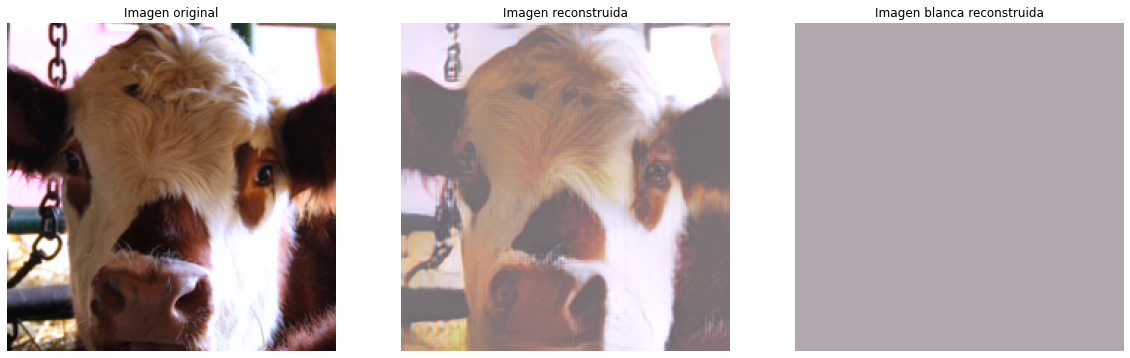

In [64]:
reBuildPlotter(3564, layer = 5, VGG16 =False, save=False, name="UWUWUWU")

# Trasferencia de Estilos

## WCT

In [27]:
#Código de wct extraído de GitHub del paper
def wct(alpha, cf, sf, s1f=None, beta=None):

    # content image whitening
    cf = cf.double()
    c_channels, c_width, c_height = cf.size(0), cf.size(1), cf.size(2)
    cfv = cf.view(c_channels, -1)  # c x (h x w)

    c_mean = torch.mean(cfv, 1) # perform mean for each row
    c_mean = c_mean.unsqueeze(1).expand_as(cfv) # add dim and replicate mean on rows
    cfv = cfv - c_mean # subtract mean element-wise

    c_covm = torch.mm(cfv, cfv.t()).div((c_width * c_height) - 1)  # construct covariance matrix
    c_u, c_e, c_v = torch.svd(c_covm, some=False) # singular value decomposition

    k_c = c_channels
    for i in range(c_channels):
        if c_e[i] < 0.00001:
            k_c = i
            break
    c_d = (c_e[0:k_c]).pow(-0.5)

    w_step1 = torch.mm(c_v[:, 0:k_c], torch.diag(c_d))
    w_step2 = torch.mm(w_step1, (c_v[:, 0:k_c].t()))
    whitened = torch.mm(w_step2, cfv)

    # style image coloring
    sf = sf.double()
    _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
    sfv = sf.view(c_channels, -1)

    s_mean = torch.mean(sfv, 1)
    s_mean = s_mean.unsqueeze(1).expand_as(sfv)
    sfv = sfv - s_mean

    s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
    s_u, s_e, s_v = torch.svd(s_covm, some=False)

    s_k = c_channels # same number of channels ad content features
    for i in range(c_channels):
        if s_e[i] < 0.00001:
            s_k = i
            break
    s_d = (s_e[0:s_k]).pow(0.5)

    c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
    c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
    colored = torch.mm(c_step2, whitened)

    cs0_features = colored + s_mean.resize_as_(colored)
    cs0_features = cs0_features.view_as(cf)

    # additional style coloring
    if beta:
        sf = s1f
        sf = sf.double()
        _, s_width, s_heigth = sf.size(0), sf.size(1), sf.size(2)
        sfv = sf.view(c_channels, -1)

        s_mean = torch.mean(sfv, 1)
        s_mean = s_mean.unsqueeze(1).expand_as(sfv)
        sfv = sfv - s_mean

        s_covm = torch.mm(sfv, sfv.t()).div((s_width * s_heigth) - 1)
        s_u, s_e, s_v = torch.svd(s_covm, some=False)

        s_k = c_channels
        for i in range(c_channels):
            if s_e[i] < 0.00001:
                s_k = i
                break
        s_d = (s_e[0:s_k]).pow(0.5)

        c_step1 = torch.mm(s_v[:, 0:s_k], torch.diag(s_d))
        c_step2 = torch.mm(c_step1, s_v[:, 0:s_k].t())
        colored = torch.mm(c_step2, whitened)

        cs1_features = colored + s_mean.resize_as_(colored)
        cs1_features = cs1_features.view_as(cf)

        target_features = beta * cs0_features + (1.0 - beta) * cs1_features
    else:
        target_features = cs0_features

    ccsf = alpha * target_features + (1.0 - alpha) * cf
    return ccsf.float().unsqueeze(0)

## Array de Estilos

In [28]:
styledir = "styles"
styleobj = natsorted(os.listdir(styledir))
# #Entonces puedo armar una lista con todas las direcciones
styleArray = []
for i in range(0, len(styleobj)):
   styleArray.append(os.path.join(styledir, styleobj[i]))

In [29]:
styles = CustomDataSetImg(styleArray, transform = transform1)

## Array de Imagenes para probar

In [75]:
imagedir = "Images"
imageobj = natsorted(os.listdir(imagedir))
# #Entonces puedo armar una lista con todas las direcciones
imageArray = []
for i in range(0, len(imageobj)):
   imageArray.append(os.path.join(imagedir, imageobj[i]))

In [76]:
images = CustomDataSetImg(imageArray, transform = transform1)

## Implementación de wct

In [32]:
def wctvgg16(alpha,image, style, encoder, decoder):

    with torch.no_grad(): #Porque wct no admite gradiente
        cf = encoder(image.cuda())
        sf = encoder(style.cuda())
        result = wct(alpha = alpha, cf = cf, sf = sf)
    return decoder(result) #El [0] es porque wct entrega en formato B x C x (H x W)

In [33]:
if not (next(Encode.parameters()).is_cuda and next(Decode.parameters()).is_cuda):
    Encode.cpu()
    Decode.cpu()

### codigo resultados

In [34]:
def stylePlotter(alpha, imgIdx, styleIdx, layer, VGG16 = True, save=False, name="result"):
    if VGG16:
        encLayers = [3, 8, 15, 22, 25]
        decLayers = [26, 21, 14, 8, 5]
        dec = Decoder(layer = decLayers[layer - 1])
        enc = Encoder(layer = encLayers[layer - 1])

        dec.load_state_dict(torch.load(f'Best Models and Losses\{layer}L.pt'))

    else:
        dec = Decoder19(depth = layer)
        enc = Encoder19(depth = layer)

    if not (next(enc.parameters()).is_cuda and next(dec.parameters()).is_cuda):
        enc.cuda()
        dec.cuda()

    Tf = wctvgg16(alpha = alpha, image = images[imgIdx][0].cuda(), style = styles[styleIdx][0].cuda(), encoder = enc, decoder = dec)
    fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize = (20,20))
    ax1.imshow(denormalize(images[imgIdx][0]).permute(1,2,0))
    ax1.set_axis_off()
    ax1.title.set_text("Imagen original")
    # graph = torch.squeeze(denormalize(dec(enc(images[imgIdx][0].cuda())[None,...]).detach().cpu()))
    # ax2.imshow(graph.permute(1,2,0))
    # ax2.set_axis_off()
    # ax2.title.set_text("Imagen reconstruida")
    graph1 = torch.squeeze(denormalize(Tf.detach().cpu()))
    ax2.imshow(graph1.permute(1,2,0)) 
    ax2.set_axis_off()
    ax2.title.set_text(f"Imagen con transferencia, alpha = {alpha}")

    ax3.imshow(denormalize(styles[styleIdx][0]).permute(1,2,0))
    ax3.set_axis_off()
    ax3.title.set_text("Imagen de referencia")
    if save:
        plt.savefig(f"{name}.pdf", dpi = 300, bbox_inches='tight')
    plt.show() 

## Resultados

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


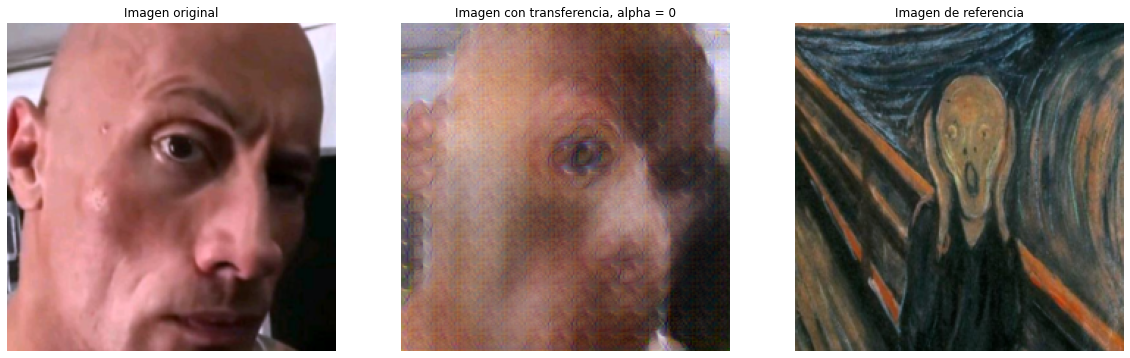

In [35]:
stylePlotter(alpha=0, imgIdx=5, styleIdx=6, layer=5, VGG16=True, save=False, name="beanos")

In [36]:
def MultilayerST(maxL,minL, image, style, alpha):
    Deco1 = Decoder(layer = 26)
    # Deco1FULL6epc.pt
    Deco1.load_state_dict(torch.load('Best Models and Losses/1L.pt'))

    Deco2 = Decoder(layer = 21)
    #Deco2FULL7epc.pt
    Deco2.load_state_dict(torch.load('Best Models and Losses/2L.pt'))


    Deco3 = Decoder(layer = 14)
    #3L-12.pt
    Deco3.load_state_dict(torch.load('Best Models and Losses/3L.pt'))

    Deco4 = Decoder(layer = 8)
    #Deco4FULL46epc.pt
    Deco4.load_state_dict(torch.load('Best Models and Losses/4L.pt'))

    Deco5 = Decoder(layer = 5)
    #5L-N-29.pt
    Deco5.load_state_dict(torch.load('Best Models and Losses/5L.pt'))

    result = image

    E_list = [25,22,15,8,3] 
    Decoders = [Deco5, Deco4, Deco3, Deco2, Deco1]

    for i in range(5-maxL,6-minL):
        enc = Encoder(E_list[i])
        dec = Decoders[i]
        if not (next(enc.parameters()).is_cuda and next(dec.parameters()).is_cuda):
            enc.cuda()
            dec.cuda()
        result = torch.squeeze(wctvgg16(alpha, result,style, enc, dec))

    return denormalize(result).detach()

### Funcion que grafica Transferencia de estilos multicapa

In [37]:
def MultilayerPlotter(maxL, minL, imgIdx, styleIdx, alpha, VGG16= True, save= False, name = "multi"):
    if VGG16:
        Tf = MultilayerST(maxL,minL, images[imgIdx][0].cuda(), styles[styleIdx][0].cuda(), alpha)
    else:
        Tf = MultilayerST19(maxL,minL, images[imgIdx][0].cuda(), styles[styleIdx][0].cuda(), alpha)

    fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize = (20,20))
    ax1.imshow(denormalize(images[imgIdx][0]).permute(1,2,0))
    ax1.set_axis_off()
    ax1.title.set_text("Imagen original")


    graph1 = torch.squeeze(Tf.detach().cpu())
    ax2.imshow(graph1.permute(1,2,0)) 
    ax2.set_axis_off()
    ax2.title.set_text(f"Imagen con transferencia, alpha = {alpha}")

    ax3.imshow(denormalize(styles[styleIdx][0]).permute(1,2,0))
    ax3.set_axis_off()
    ax3.title.set_text("Imagen de referencia")
    if save:
        plt.savefig(f"{name}.pdf", dpi = 300, bbox_inches='tight')
    plt.show() 

In [38]:
styleArray

['styles\\Desert.png',
 'styles\\Girl.jpg',
 'styles\\Landscape.png',
 'styles\\Melting.jpg',
 'styles\\Monedas.jpg',
 'styles\\Retrowave.webp',
 'styles\\Scream.jpg',
 'styles\\Tree.jpg',
 'styles\\a1.png',
 'styles\\chicken.jpg',
 'styles\\cubism.jpg',
 'styles\\dragon.jpg',
 'styles\\flor-broly.png',
 'styles\\forest.jpg',
 'styles\\metalFloor.jpg',
 'styles\\river.jpg',
 'styles\\tiger.jpg']

In [77]:
imageArray

['Images\\Adam',
 'Images\\Betito',
 'Images\\Castle.png',
 'Images\\Giovanni.jpg',
 'Images\\NoReLU.jpg',
 'Images\\Rock.jpeg',
 'Images\\Toad.webp',
 'Images\\Windows.jpg',
 'Images\\beanos.jpg',
 'Images\\bruh.jpg',
 'Images\\forg.jpg',
 'Images\\sadCat.png',
 'Images\\susCat.jpg']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


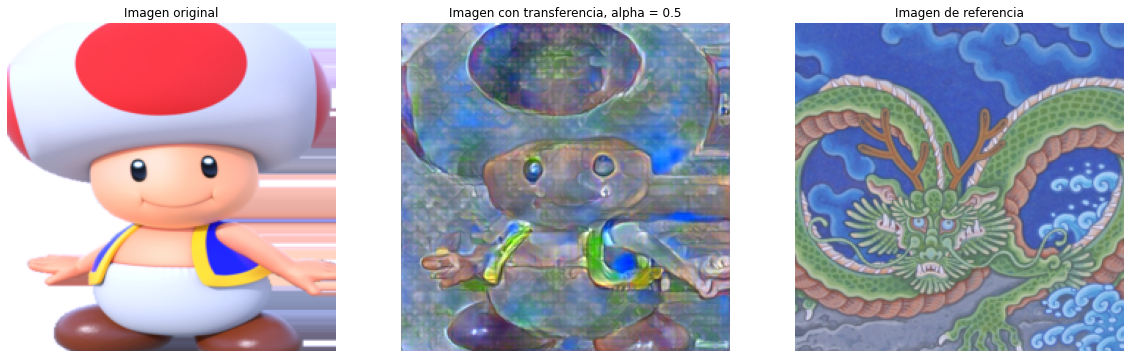

In [78]:
MultilayerPlotter(4, 1, imgIdx= 6, styleIdx= 11, alpha=0.5, VGG16= True, save= False, name = "multi")

# Curvas de entrenamiento

## L1

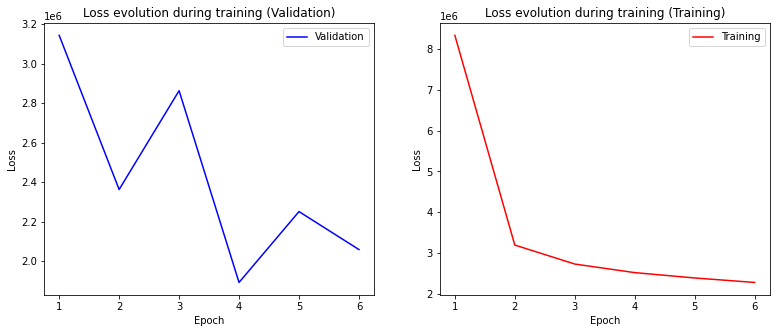

In [44]:
L1 = torch.load('Best Models and Losses\Loss1L.pt')
show_curves(L1)

## L2

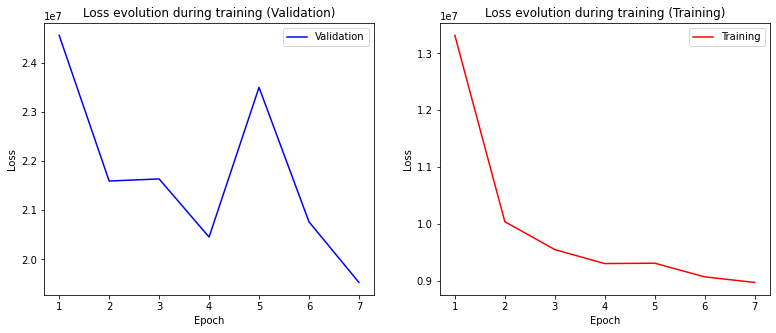

In [45]:
L2 = torch.load('Best Models and Losses\Loss2L.pt')
show_curves(L2)

## L3

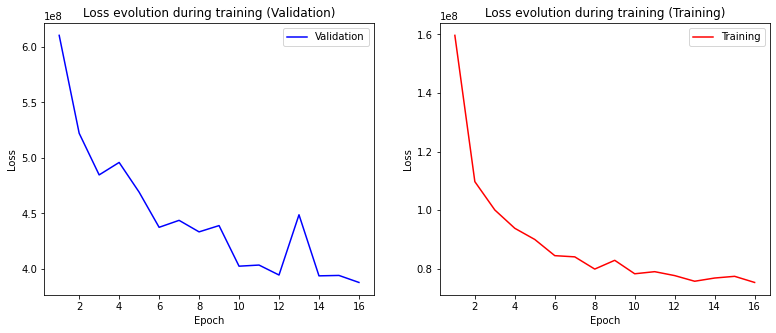

In [46]:
L3 = torch.load('Best Models and Losses\loss-3L.pt')
show_curves(L3)

## L4

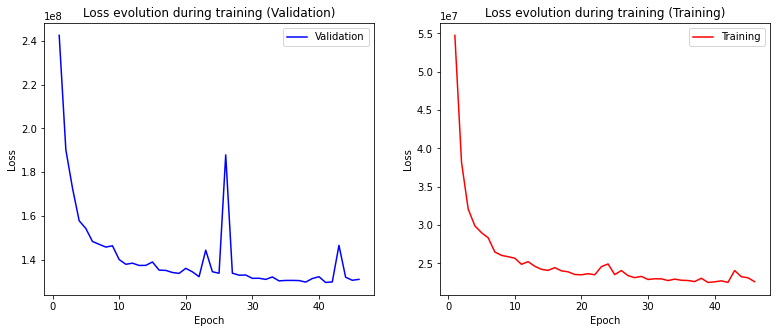

In [47]:
L4 = torch.load('Best Models and Losses\Loss4L.pt')
show_curves(L4)

## L5

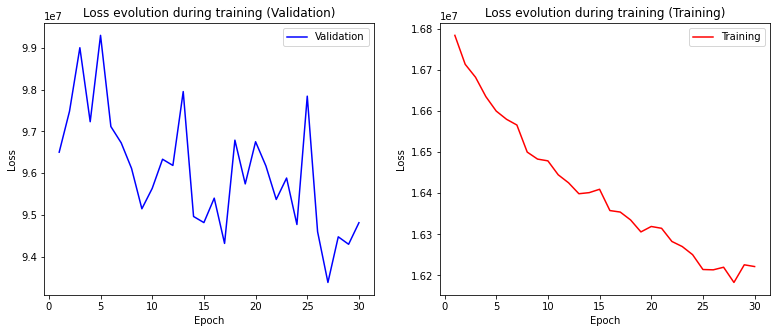

In [48]:
L5 = torch.load('Best Models and Losses\loss-5L.pt')
show_curves(L5)

# VGG19

In [49]:
import torch
import torch.nn as nn
from VGG19.models.autoencoder_vgg19.vgg19_1 import vgg_normalised_conv1_1, feature_invertor_conv1_1
from VGG19.models.autoencoder_vgg19.vgg19_2 import vgg_normalised_conv2_1, feature_invertor_conv2_1
from VGG19.models.autoencoder_vgg19.vgg19_3 import vgg_normalised_conv3_1, feature_invertor_conv3_1
from VGG19.models.autoencoder_vgg19.vgg19_4 import vgg_normalised_conv4_1, feature_invertor_conv4_1
from VGG19.models.autoencoder_vgg19.vgg19_5 import vgg_normalised_conv5_1, feature_invertor_conv5_1

class Encoder19(nn.Module):

    def __init__(self, depth):
        super(Encoder19, self).__init__()

        assert(type(depth).__name__ == 'int' and 1 <= depth <= 5)
        self.depth = depth

        if depth == 1:
            self.model = vgg_normalised_conv1_1.vgg_normalised_conv1_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_1/vgg_normalised_conv1_1.pth"))
        elif depth == 2:
            self.model = vgg_normalised_conv2_1.vgg_normalised_conv2_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_2/vgg_normalised_conv2_1.pth"))
        elif depth == 3:
            self.model = vgg_normalised_conv3_1.vgg_normalised_conv3_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_3/vgg_normalised_conv3_1.pth"))
        elif depth == 4:
            self.model = vgg_normalised_conv4_1.vgg_normalised_conv4_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_4/vgg_normalised_conv4_1.pth"))
        elif depth == 5:
            self.model = vgg_normalised_conv5_1.vgg_normalised_conv5_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_5/vgg_normalised_conv5_1.pth"))


    def forward(self, x):
        out = self.model(x)
        return out


class Decoder19(nn.Module):
    def __init__(self, depth):
        super(Decoder19, self).__init__()

        assert (type(depth).__name__ == 'int' and 1 <= depth <= 5)
        self.depth = depth

        if depth == 1:
            self.model = feature_invertor_conv1_1.feature_invertor_conv1_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_1/feature_invertor_conv1_1.pth"))
        elif depth == 2:
            self.model = feature_invertor_conv2_1.feature_invertor_conv2_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_2/feature_invertor_conv2_1.pth"))
        elif depth == 3:
            self.model = feature_invertor_conv3_1.feature_invertor_conv3_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_3/feature_invertor_conv3_1.pth"))
        elif depth == 4:
            self.model = feature_invertor_conv4_1.feature_invertor_conv4_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_4/feature_invertor_conv4_1.pth"))
        elif depth == 5:
            self.model = feature_invertor_conv5_1.feature_invertor_conv5_1
            self.model.load_state_dict(torch.load("VGG19/models/autoencoder_vgg19/vgg19_5/feature_invertor_conv5_1.pth"))

    def forward(self, x):
        out = self.model(x)
        return out

In [50]:
def MultilayerST19(maxL,minL, image, style, alpha):
    result = image
    for i in range(maxL,minL-1, -1):
        enc = Encoder19(depth = i)
        dec = Decoder19(depth = i)
        if not (next(enc.parameters()).is_cuda and next(dec.parameters()).is_cuda):
            enc.cuda()
            dec.cuda()
        result = torch.squeeze(wctvgg16(alpha, result, style, encoder= enc, decoder= dec))

    return denormalize(result).detach().cpu()

In [51]:

def M_std_values(Val, model, criterion, deco, use_gpu):

    def validation(val_loader, model, criterion, deco , use_gpu = False):
        cumulative_loss = 0
        mean_array = []
        
        if not (next(model.parameters()).is_cuda and next(deco.parameters()).is_cuda):
            model.cuda()
            deco.cuda()

        for x_val, y_val in val_loader:

            if use_gpu:
                x_val = x_val.cuda()
                y_val = y_val.cuda()

            y_predicted = model(x_val)
            ydif = y_predicted - y_val
            fdif = deco(y_predicted) - x_val

            
            loss = criterion(ydif, fdif)

            cumulative_loss += loss.item()
            mean_array.append(loss.item())
            

        val_loss = cumulative_loss / len(val_loader)
        std = np.std(mean_array)
        del x_val, y_val

        return val_loss, std
  
    val_loader = torch.utils.data.DataLoader(Val, batch_size= 10, shuffle=False, pin_memory=use_gpu)

    model.eval()
    with torch.no_grad():
        val_loss, std = validation(val_loader, model, criterion,deco, use_gpu)
    
    return val_loss, std



In [52]:
def vgg16vs19(Dirdata, layer):
    print(f"------Val loss layer {layer}-----")
    encLayers = [3, 8, 15, 22, 25]
    decLayers = [26, 21, 14, 8, 5]

    d19 = Decoder19(depth = layer)
    e19 = Encoder19(depth = layer)

    if not (next(e19.parameters()).is_cuda and next(d19.parameters()).is_cuda):
        e19.cuda()
        d19.cuda()
    Val = CustomDataSetTensor(Dirdata, encoder = e19)
    results19 = M_std_values(Val, d19, criterion = DecoderLoss(), deco = e19, use_gpu=True)
    print('----------VGG19----------')
    print(f'media = {results19[0]:.2f} y desviación estándar = {results19[1]:.2f}')
    print(" ")

    d16 = Decoder(layer = decLayers[layer - 1])
    e16 = Encoder(layer = encLayers[layer - 1])
    if not (next(e16.parameters()).is_cuda and next(d16.parameters()).is_cuda):
        e16.cuda()
        d16.cuda()
    d16.load_state_dict(torch.load(f'Best Models and Losses\{layer}L.pt'))
    Val = CustomDataSetTensor(Dirdata, encoder = e16)
    results16 = M_std_values(Val, d16, criterion = DecoderLoss(), deco = e16, use_gpu=True)
    print('----------VGG16----------')
    print(f'media = {results16[0]:.2f} y desviación estándar = {results16[1]:.2f}')
    print(" ")

In [53]:
vgg16vs19(dirVal[:1000], 1)

------Val loss layer 1-----
----------VGG19----------
media = 30058953.18 y desviación estándar = 4620866.92
 
----------VGG16----------
media = 583868.24 y desviación estándar = 49177.74
 
